# Pinecone

- Author: [ro__o_jun](https://github.com/ro-jun)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/01-OpenAIEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/01-OpenAIEmbeddings.ipynb)

## Overview

This tutorial provides a comprehensive guide to integrating `Pinecone` with `LangChain` for creating and managing high-performance vector databases.  

It explains how to set up `Pinecone` , `preprocess documents` , `handle stop words` , and utilize Pinecone's APIs for vector indexing and `document retrieval` .  

Additionally, it demonstrates advanced features like `hybrid search` using `dense` and `sparse embeddings` , `metadata filtering` , and `dynamic reranking` to build efficient and scalable search systems.  

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [What is Pinecone?](#what-is-pinecone)
- [Pinecone setup guide](#Pinecone-setup-guide)
- [Handling Stop Words](#handling-stop-words)
- [Data preprocessing](#data-preprocessing)
- [Pinecone and LangChain Integration Guide: Step by Step](#pinecone-and-langchain-integration-guide-step-by-step)
- [Pinecone: Add to DB Index (Upsert)](#pinecone-add-to-db-index-upsert)
- [Index inquiry/delete](#index-inquirydelete)
- [Create HybridRetrieve](#create-hybridretrieve)
- [Using multimodal](#Using-multimodal)


### References

- [Langchain-PineconeVectorStore](https://python.langchain.com/api_reference/pinecone/vectorstores/langchain_pinecone.vectorstores.PineconeVectorStore.html)
- [Langchain-Retrievers](https://python.langchain.com/docs/integrations/retrievers/pinecone_hybrid_search/)
- [Langchain-OpenClip](https://python.langchain.com/docs/integrations/text_embedding/open_clip/)
- [Pinecone-Docs](https://docs.pinecone.io/guides/get-started/overview)
- [Pinecone-Docs-integrations](https://docs.pinecone.io/integrations/langchain)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-pinecone",
        "pinecone[grpc]",
        "nltk",
        "langchain_community",
        "pymupdf",
        "langchain-openai",
        "pinecone-text",
        "langchain-huggingface",
        "open_clip_torch",
        "langchain-experimental",
        "pillow",
        "matplotlib",
        "datasets >= 3.2.0",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "PINECONE_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Pinecone",
        "HUGGINGFACEHUB_API_TOKEN": "",
    },
)

Environment variables have been set successfully.


[Note] If you are using a `.env` file, proceed as follows.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## What is Pinecone?

`Pinecone` is a **cloud-based** , high-performance vector database for **efficient vector storage and retrieval** in AI and machine learning applications.

**Features** :
1. **Supports SDKs** for Python, Node.js, Java, and Go.
2. **Fully managed** : Reduces the burden of infrastructure management.
3. **Real-time updates** : Supports real-time insertion, updates, and deletions.

**Advantages** :
1. Scalability for large datasets.
2. Real-time data processing.
3. High availability with cloud infrastructure.

**Disadvantages** :
1. Relatively higher cost compared to other vector databases.
2. Limited customization options.

## Pinecone setup guide

This section explains how to set up `Pinecone` , including `API key` creation.

**[steps]**

1. Log in to [Pinecone](https://www.pinecone.io/)
2. Create an API key under the `API Keys` tab.

![example](./assets/04-pinecone-api-01.png)  
![example](./assets/04-pinecone-api-02.png)  

## Handling Stop Words
- Process stopwords before vectorizing text data to improve the quality of embeddings and focus on meaningful words.

In [5]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thdgh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thdgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\thdgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Customizing stopword users

In [6]:
from nltk.corpus import stopwords

default_stop_words = stopwords.words("english")
print("Number of stop words :", len(default_stop_words))
print("Print 10 stop words :", default_stop_words[:10])
print()

# Add any stop words you want to add.
user_defined_stop_words = [
    "example1",
    "example2",
    "",
]

combined_stop_words = list(set(default_stop_words + user_defined_stop_words))

print("Number of stop words:", len(combined_stop_words))
print("Print 10 stop words:", combined_stop_words[:10])

Number of stop words : 179
Print 10 stop words : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Number of stop words: 182
Print 10 stop words: ['them', 'her', '', "couldn't", 'ma', "isn't", 'that', 'about', 'in', 'wouldn']


## Data preprocessing

Below is the preprocessing process for general documents.  
Reads all `.pdf` files under `ROOT_DIR` and saves them in `document_lsit.`

In [7]:
import re
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import glob


# Text cleaning function
def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    # Remove multiple spaces and trim the text
    text = re.sub(r"\s+", " ", text).strip()
    # Remove abnormal strings with special characters and numbers
    text = re.sub(r"[0-9#%$&()*+,\-./:;<=>?@\[\]^_`{|}~]{3,}", "", text)
    return text

# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

split_docs = []

# Read and preprocess PDF files
files = sorted(glob.glob("data/*.pdf"))

for file in files:
    loader = PyMuPDFLoader(file)
    raw_docs = loader.load_and_split(text_splitter)

    for doc in raw_docs:
        # Filter non-text data
        doc.page_content = clean_text(doc.page_content)
        split_docs.append(doc)

# Check the number of documents
print(f"Number of documents after processing: {len(split_docs)}")

Number of documents after processing: 414


In [8]:
split_docs[12].page_content

'up. I have a serious reason: he is the best friend I have in the world. I have another reason: this grown-up understands everything, even books about children. I have a third reason: he lives in France where he is hungry and cold. He needs cheering up. If all these'

In [9]:
split_docs[12].metadata

{'source': 'data\\TheLittlePrince.pdf',
 'file_path': 'data\\TheLittlePrince.pdf',
 'page': 2,
 'total_pages': 64,
 'format': 'PDF 1.3',
 'title': '',
 'author': 'Paula MacDowell',
 'subject': '',
 'keywords': '',
 'creator': 'Safari',
 'producer': 'Mac OS X 10.10.5 Quartz PDFContext',
 'creationDate': "D:20160209011144Z00'00'",
 'modDate': "D:20160209011144Z00'00'",
 'trapped': ''}

Performs document processing to save DB in Pinecone. You can select `metadata_Keys` during this process.

You can additionally tag metadata and, if desired, add and process metadata ahead of time in a preprocessing task.

- `split_docs` : List[Document] containing the results of document splitting.
- `metadata_keys` : List containing metadata keys to be added to the document.
- `min_length` : Specifies the minimum length of the document. Documents shorter than this length are excluded.
- `use_basename` : Specifies whether to use the file name based on the source path. The default is `False` .

**Preprocessing of documents**

- Extract the required `metadata` information.
- Filters only data longer than the minimum length.
- Specifies whether to use the document's `basename` . The default is `False` .
- Here, `basename` refers to the very last part of the file.
- For example, `/data/final-Research-Paper-5.pdf` becomes `final-Research-Paper-5.pdf`.


In [10]:
split_docs[16].metadata

{'source': 'data\\TheLittlePrince.pdf',
 'file_path': 'data\\TheLittlePrince.pdf',
 'page': 3,
 'total_pages': 64,
 'format': 'PDF 1.3',
 'title': '',
 'author': 'Paula MacDowell',
 'subject': '',
 'keywords': '',
 'creator': 'Safari',
 'producer': 'Mac OS X 10.10.5 Quartz PDFContext',
 'creationDate': "D:20160209011144Z00'00'",
 'modDate': "D:20160209011144Z00'00'",
 'trapped': ''}

In [11]:
from tqdm import tqdm
import os

# Add the metadata key you want to add from document metadata to the vector database.
metadata_keys = [
    "source",
    "page",
    "author",
]
min_length = 5  # Set minimum length to enter vector storage
use_basename = True  # If True, extract only the file name (not the full path) for the "source" metadata key.

# Initialize variables to store results
contents = []
metadatas = {key: [] for key in metadata_keys}

# Document preprocessing tasks
for doc in tqdm(split_docs):
    content = doc.page_content.strip()
    if (
        content and len(content) >= min_length
    ):  # Condition: Not empty and at least minimum length
        contents.append(content)
        for k in metadata_keys:
            value = doc.metadata.get(k)  # Get metadata key
            if k == "source" and use_basename:  # use_basename processing
                value = os.path.basename(value)
            try:
                metadatas[k].append(int(value))
            except (ValueError, TypeError):
                metadatas[k].append(value)

# Check documents, metadata to be saved in VectorStore
print("Processed contents:", contents[15:20])
print()
print("Processed metadatas keys:", metadatas.keys())
print()
print("Source metadata examples:", metadatas["source"][:5])

100%|██████████| 414/414 [00:00<00:00, 91531.38it/s]

Processed contents: ['copy of the drawing. In the book it said: "Boa constrictors swallow their prey whole, without chewing it. After that they are not able to move, and they sleep through the six months that they need for digestion."', 'I pondered deeply, then, over the adventures of the jungle. And after some work with a colored pencil I succeeded in making my first drawing. My Drawing Number One. It looked something like this: I showed my masterpiece to the grown-ups, and asked them whether the drawing frightened them.', 'But they answered: "Frighten? Why should any one be frightened by a hat?" My drawing was not a picture of a hat. It was a picture of a boa constrictor digesting an elephant. But since the grown-ups were not able to understand it, I made another drawing: I drew the inside of a boa', "constrictor, so that the grown-ups could see it clearly. They always need to have things explained. My Drawing Number Two looked like this: The grown-ups' response, this time, was to ad

In [12]:
# Check number of documents, check number of sources, check number of pages
len(contents), len(metadatas["source"]), len(metadatas["page"]), len(
    metadatas["author"]
)

(414, 414, 414, 414)

## Pinecone and LangChain Integration Guide: Step by Step

This guide outlines the integration of Pinecone and LangChain to set up and utilize a vector database. 

Below are the key steps to complete the integration.

### Pinecone client initialization and vector database setup

The provided code performs the initialization of a Pinecone client, sets up an index in Pinecone, and defines a vector database to store embeddings.

**[caution]**    

If you are considering HybridSearch, specify the metric as dotproduct.  
Basic users cannot use PodSpec.  

### Pinecone index settings

**This explains how to create and check indexes.**

In [50]:
import os, time
from pinecone import ServerlessSpec, PodSpec
try:
    from pinecone.grpc import PineconeGRPC as Pinecone
except: 
    from pinecone import Pinecone

# Initialize Pinecone client with API key from environment variables
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

# Set to True when using the serverless method, and False when using the PodSpec method.
use_serverless = True

if use_serverless:
    spec = ServerlessSpec(cloud="aws", region="us-east-1")
else:
    spec = PodSpec(environment="us-west1-gcp", pod_type="p1.x1", pods=1)

index_name = "langchain-opentutorial-index"

# Check existing index name
all_indexes = pc.list_indexes()
print(f"Full Index Data: {all_indexes}")
existing_indexes = [index.name for index in all_indexes]
print(f"Extracted Index Names: {existing_indexes}")

# Check existing index and handle deletion/creation
if index_name in existing_indexes:
    print(f"Using existing index: {index_name}")
    index = pc.Index(index_name)
else:
    print(f"Creating new index: {index_name}")
    pc.create_index(
        index_name,
        dimension=3072,
        metric="dotproduct",
        spec=spec,
    )
    index = pc.Index(index_name)

# Check index readiness
while not pc.describe_index(index_name).status["ready"]:
    time.sleep(1)
print(f"Index '{index_name}' is ready.")

Full Index Data: [{
    "name": "langchain-opentutorial-index",
    "dimension": 3072,
    "metric": "dotproduct",
    "host": "langchain-opentutorial-index-9v46jum.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}, {
    "name": "langchain-opentutorial-multimodal-1024",
    "dimension": 1024,
    "metric": "dotproduct",
    "host": "langchain-opentutorial-multimodal-1024-9v46jum.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}]
Extracted Index Names: ['langchain-opentutorial-index', 'langchain-opentutorial-multimodal-1024']
Using existing index: langchain-opentutorial-i

**This is how to check the inside of an index.**

In [14]:
index = pc.Index(index_name)
print(index.describe_index_stats())

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}


![04-pinecone-index.png](./assets/04-pinecone-index.png)

**This is how to clear an index.**

**[Note]** If you want to delete the index, uncomment the lines below and run the code.

In [ ]:
# index_name = "langchain-opentutorial-index"

# pc.delete_index(index_name)
# print(pc.list_indexes())

[]


## Create Sparse Encoder

- Create a sparse encoder.

- Perform stopword processing.

- Learn contents using Sparse Encoder. The encode learned here is used to create a Sparse Vector when storing documents in VectorStore.


Simplified NLTK-based BM25 tokenizer

In [17]:
import string
from typing import List, Optional
import nltk


class NLTKBM25Tokenizer:
    def __init__(self, stop_words: Optional[List[str]] = None):
        # Set stop words and punctuation
        self._stop_words = set(stop_words) if stop_words else set()
        self._punctuation = set(string.punctuation)

    def __call__(self, text: str) -> List[str]:
        # Tokenization using NLTK
        tokens = nltk.word_tokenize(text)
        # Remove stop words and punctuation
        return [
            word.lower()
            for word in tokens
            if word not in self._punctuation and word.lower() not in self._stop_words
        ]

In [18]:
from pinecone_text.sparse import BM25Encoder

# BM25Encoder initialization
sparse_encoder = BM25Encoder(language="english")

# Setting up a custom tokenizer on BM25Encoder
sparse_encoder._tokenizer = NLTKBM25Tokenizer(stop_words=default_stop_words)

print("BM25Encoder with NLTK tokenizer applied successfully!")

BM25Encoder with NLTK tokenizer applied successfully!


Train the corpus on Sparse Encoder.

- `save_path` : Path to save Sparse Encoder. Later, the Sparse Encoder saved in pickle format will be loaded and used for query embedding. Therefore, specify the path to save it.

In [19]:
import pickle

save_path = "./sparse_encoder.pkl"

# Learn and save Sparse Encoder.
sparse_encoder.fit(contents)
with open(save_path, "wb") as f:
    pickle.dump(sparse_encoder, f)
print(f"[fit_sparse_encoder]\nSaved Sparse Encoder to: {save_path}")

  0%|          | 0/414 [00:00<?, ?it/s]

[fit_sparse_encoder]
Saved Sparse Encoder to: ./sparse_encoder.pkl


[Optional]  
Below is the code to use when you need to reload the learned and saved Sparse Encoder later.

In [20]:
file_path = "./sparse_encoder.pkl"

# It is used later to load the learned sparse encoder.
try:
    with open(file_path, "rb") as f:
        loaded_file = pickle.load(f)
    print(f"[load_sparse_encoder]\nLoaded Sparse Encoder from: {file_path}")
    sparse_encoder = loaded_file
except Exception as e:
    print(f"[load_sparse_encoder]\n{e}")
    sparse_encoder = None

[load_sparse_encoder]
Loaded Sparse Encoder from: ./sparse_encoder.pkl


## Pinecone: Add to DB Index (Upsert)

![04-pinecone-upsert](./assets/04-pinecone-upsert.png)

- `context`: This is the content of the document.
- `page` : The page number of the document.
- `source` : This is the source of the document.
- `values` : This is an embedding of a document obtained through Embedder.
- `sparse values` : This is an embedding of a document obtained through Sparse Encoder.

Upsert documents in batches without distributed processing.
If the amount of documents is not large, use the method below.

In [21]:
from tqdm import tqdm


# Function to handle vector creation and Pinecone upsert simultaneously
def upsert_documents(
    index, contents, metadatas, embedder, sparse_encoder, namespace, batch_size=32
):
    total_batches = (len(contents) + batch_size - 1) // batch_size

    for batch_start in tqdm(
        range(0, len(contents), batch_size),
        desc="Processing Batches",
        total=total_batches,
    ):
        batch_end = min(batch_start + batch_size, len(contents))

        # Extract current batch data
        context_batch = contents[batch_start:batch_end]
        metadata_batch = {
            key: metadatas[key][batch_start:batch_end] for key in metadatas
        }

        # Dense vector creation (batch)
        dense_vectors = embedder.embed_documents(context_batch)

        # Sparse vector creation (batch)
        sparse_vectors = sparse_encoder.encode_documents(context_batch)

        # Configuring data to upsert into Pinecone
        vectors = [
            {
                "id": f"doc-{batch_start + i}",
                "values": dense_vectors[i],
                "sparse_values": {
                    "indices": sparse_vectors[i]["indices"],
                    "values": sparse_vectors[i]["values"],
                },
                "metadata": {
                    **{key: metadata_batch[key][i] for key in metadata_batch},
                    "context": content,  # add content
                },
            }
            for i, content in enumerate(context_batch)
        ]

        # Upsert to Pinecone
        index.upsert(vectors=vectors, namespace=namespace)

    print(index.describe_index_stats())

In [22]:
from langchain_openai import OpenAIEmbeddings

openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Please set
embedder = openai_embeddings
batch_size = 32
namespace = "langchain-opentutorial-01"

# Running upsert on Pinecone
upsert_documents(
    index=index,
    contents=contents,
    metadatas=metadatas,
    embedder=openai_embeddings,
    sparse_encoder=sparse_encoder,
    namespace=namespace,
    batch_size=batch_size,
)

Processing Batches: 100%|██████████| 13/13 [00:37<00:00,  2.86s/it]


{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'langchain-opentutorial-01': {'vector_count': 0}},
 'total_vector_count': 0}


Below, distributed processing is performed to quickly upsert large documents. Use this for large uploads.

In [23]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


# Functions to process individual batches
def process_batch(
    index,
    context_batch,
    metadata_batch,
    embedder,
    sparse_encoder,
    namespace,
    batch_start,
):
    # Dense vectors creation
    dense_vectors = embedder.embed_documents(context_batch)

    # Sparse vector creation
    sparse_vectors = sparse_encoder.encode_documents(context_batch)

    # Configuring data to upsert into Pinecone
    vectors = [
        {
            "id": f"doc-{batch_start + i}",
            "values": dense_vectors[i],
            "sparse_values": {
                "indices": sparse_vectors[i]["indices"],
                "values": sparse_vectors[i]["values"],
            },
            "metadata": {
                **{key: metadata_batch[key][i] for key in metadata_batch},
                "context": content,  # add content
            },
        }
        for i, content in enumerate(context_batch)
    ]

    index.upsert(vectors=vectors, namespace=namespace)


# Distributed processing upsert function
def upsert_documents_parallel(
    index,
    contents,
    metadatas,
    embedder,
    sparse_encoder,
    namespace,
    batch_size=32,
    max_workers=8,
):
    # total_batches = (len(contents) + batch_size - 1) // batch_size  # Batch Count
    batches = [
        (
            contents[batch_start : batch_start + batch_size],
            {
                key: metadatas[key][batch_start : batch_start + batch_size]
                for key in metadatas
            },
            batch_start,
        )
        for batch_start in range(0, len(contents), batch_size)
    ]

    # Parallel processing using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
                process_batch,
                index,
                batch[0],
                batch[1],
                embedder,
                sparse_encoder,
                namespace,
                batch[2],
            )
            for batch in batches
        ]

        # Display parallel job status with tqdm
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Processing Batches in Parallel",
        ):
            future.result()

In [24]:
from langchain_openai import OpenAIEmbeddings

openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

embedder = openai_embeddings
# Set batch size and number of workers
batch_size = 32
max_workers = 8
namespace = "langchain-opentutorial-02"

# Running Upsert in Parallel on Pinecone
upsert_documents_parallel(
    index=index,
    contents=contents,
    metadatas=metadatas,
    embedder=openai_embeddings,
    sparse_encoder=sparse_encoder,
    namespace=namespace,
    batch_size=batch_size,
    max_workers=max_workers,
)

Processing Batches in Parallel: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


In [25]:
print(index.describe_index_stats()) 

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'langchain-opentutorial-01': {'vector_count': 414},
                'langchain-opentutorial-02': {'vector_count': 414}},
 'total_vector_count': 828}


![04-pinecone-namespaces-01.png](./assets/04-pinecone-namespaces-01.png)

## Index inquiry/delete

The `describe_index_stats` method provides statistical information about the contents of an index. This method allows you to obtain information such as the number of vectors and dimensions per namespace.

**Parameter** * `filter` (Optional[Dict[str, Union[str, float, int, bool, List, dict]]]): A filter that returns statistics only for vectors that meet certain conditions. Default is None * `**kwargs`: Additional keyword arguments

**Return value** * `DescribeIndexStatsResponse`: Object containing statistical information about the index

**Usage example** * Default usage: `index.describe_index_stats()` * Apply filter: `index.describe_index_stats(filter={'key': 'value'})`

In [26]:
# Index lookup
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'langchain-opentutorial-01': {'vector_count': 414},
                'langchain-opentutorial-02': {'vector_count': 414}},
 'total_vector_count': 828}

**Search for documents in the index**

In [27]:
# Define your query
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

# Convert the query into dense and sparse vectors
dense_vector = embedder.embed_query(query)
sparse_vector = sparse_encoder.encode_documents(query)

# Perform hybrid search using both dense and sparse vectors
results = index.query(
    namespace="langchain-opentutorial-01",
    vector=dense_vector,
    top_k=3,
    include_metadata=True,
)

print(results)

{'matches': [{'id': 'doc-303',
              'metadata': {'author': 'Paula MacDowell',
                           'context': "o'clock in the afternoon, then at three "
                                      "o'clock I shall begin to be happy. I "
                                      'shall feel happier and happier as the '
                                      "hour advances. At four o'clock, I shall "
                                      'already be worrying and jumping about. '
                                      'I shall show you how',
                           'page': 46.0,
                           'source': 'TheLittlePrince.pdf'},
              'score': 0.69704014,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'doc-302',
              'metadata': {'author': 'Paula MacDowell',
                           'context': 'of misunderstandings. But you will sit '
                                      'a little closer to

**Delete namespace**

In [28]:
index.delete(delete_all=True, namespace="langchain-opentutorial-02")

![04-pinecone-namespaces-02.png](./assets/04-pinecone-namespaces-02.png)

In [29]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'langchain-opentutorial-01': {'vector_count': 414}},
 'total_vector_count': 414}

Below are features exclusive to paid users. Metadata filtering is available to paid users.

In [30]:
from pinecone.exceptions import PineconeException

try:
    index.delete(
        filter={"source": {"$eq": "TheLittlePrince.pdf"}},
        namespace="langchain-opentutorial-01",
    )
except PineconeException as e:
    print(f"Error while deleting using filter:\n{e}")

index.describe_index_stats()

Error while deleting using filter:
UNKNOWN:Error received from peer  {grpc_message:"Invalid request.", grpc_status:3, created_time:"2025-01-19T10:15:29.1196481+00:00"}


{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'langchain-opentutorial-01': {'vector_count': 414}},
 'total_vector_count': 414}

## Create HybridRetrieve

**PineconeHybridRetriever initialization parameter settings**

The `init_pinecone_index` function and the `PineconeHybridRetriever` class implement a hybrid search system using Pinecone. This system combines dense and sparse vectors to perform effective document retrieval.

Pinecone index initialization

The `init_pinecone_index` function initializes the Pinecone index and sets up the necessary components.

Parameters 
* `index_name` (str): Pinecone index name 
* `namespace` (str): Namespace to use 
* `api_key` (str): Pinecone API key 
* `sparse_encoder_pkl_path` (str): Sparse encoder pickle file path 
* `stopwords` (List[str]): List of stop words 
* `tokenizer` (str): Tokenizer to use (default: "nltk") 
* `embeddings` (Embeddings): Embedding model 
* `top_k` (int): Maximum number of documents to return (default: 4) 
* `alpha` (float): Weight of dense and sparse vectors Adjustment parameter (default: 0.5)

**Main features** 
1. Pinecone index initialization and statistical information output
2. Sparse encoder (BM25) loading and tokenizer settings
3. Specify namespace


In [31]:
from langchain_community.retrievers import PineconeHybridSearchRetriever
from langchain_openai import OpenAIEmbeddings
import os
try:
    from pinecone.grpc import PineconeGRPC as Pinecone
except: 
    from pinecone import Pinecone

# Step 1: Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
index_name = "langchain-opentutorial-index"
namespace = "langchain-opentutorial-01"
index = pc.Index(index_name)

# Step 2: Configure Dense and Sparse Components
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
sparse_encoder = sparse_encoder  # Pre-initialized BM25Encoder


# Step 3: Define the Retriever
class CustomPineconeHybridSearchRetriever(PineconeHybridSearchRetriever):
    def invoke(self, query, **search_kwargs):
        # Update settings dynamically
        if "top_k" in search_kwargs:
            self.top_k = search_kwargs["top_k"]
        if "alpha" in search_kwargs:
            self.alpha = search_kwargs["alpha"]
        # Apply metadata filtering if provided
        if "filter" in search_kwargs:
            kwargs = {"filter": search_kwargs["filter"]}
        else:
            kwargs = {}

        # Call the parent class method with additional kwargs
        return super().invoke(query, **kwargs)


# Step 4: Define the Retriever
retriever = CustomPineconeHybridSearchRetriever(
    embeddings=embeddings,
    sparse_encoder=sparse_encoder,
    index=index,
    namespace=namespace,
)

**Main properties** 
* `embeddings` : Embedding model for dense vector transformations 
* `sparse_encoder:` Encoder for sparse vector transformations 
* `index` : Pinecone index object 
* `top_k` : Maximum number of documents to return 
* `alpha` : Weight adjustment parameters for dense and sparse vectors 
* `namespace` : Namespace within the Pinecone index.

**Features** 
* HybridSearch Retriever combining dense and sparse vectors 
* Search strategy can be optimized through weight adjustment 
* Various dynamic metadata filtering can be applied (using `search_kwargs` : `filter` , `top_k` , `alpha` , etc.)

**Use example** 
1. Initialize required components with the `init_pinecone_index` function   
2. Create a `PineconeHybridRetriever` instance with initialized components.  
3. Perform a hybrid search using the generated retriever to create a `PineconeHybridRetriever`.

**general search**

In [32]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."
search_results = retriever.invoke(query)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

o'clock in the afternoon, then at three o'clock I shall begin to be happy. I shall feel happier and happier as the hour advances. At four o'clock, I shall already be worrying and jumping about. I shall show you how
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.4169854}


happy I am! But if you come at just any time, I shall never know at what hour my heart is to be ready to greet you . . . One must observe the proper rites . . ." "What is a rite?" asked the little prince.
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.23643838}


of misunderstandings. But you will sit a little closer to me, every day . . ." The next day the little prince came back. "It would have been better to come back at the same hour," said the fox. "If, for example, you come at four
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.21452531}


"I am very fond of sunsets. Come, let us go look at 

Using dynamic search_kwargs - k: specify maximum number of documents to return

In [33]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

search_kwargs = {"top_k": 2}
search_results = retriever.invoke(query, **search_kwargs)

for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

o'clock in the afternoon, then at three o'clock I shall begin to be happy. I shall feel happier and happier as the hour advances. At four o'clock, I shall already be worrying and jumping about. I shall show you how
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.41736686}


happy I am! But if you come at just any time, I shall never know at what hour my heart is to be ready to greet you . . . One must observe the proper rites . . ." "What is a rite?" asked the little prince.
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.23621632}





Use dynamic `search_kwargs` - `alpha` : Weight adjustment parameters for dense and sparse vectors. Specify a value between 0 and 1. `0.5` is the default, the closer it is to 1, the higher the weight of the dense vector is.

In [34]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

search_kwargs = {"alpha": 1, "top_k": 2}
search_results = retriever.invoke(query, **search_kwargs)

for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

o'clock in the afternoon, then at three o'clock I shall begin to be happy. I shall feel happier and happier as the hour advances. At four o'clock, I shall already be worrying and jumping about. I shall show you how
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.6970428}


of misunderstandings. But you will sit a little closer to me, every day . . ." The next day the little prince came back. "It would have been better to come back at the same hour," said the fox. "If, for example, you come at four
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.3908645}




In [35]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

search_kwargs = {"alpha": 0, "top_k": 2}
search_results = retriever.invoke(query, **search_kwargs)

for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

o'clock in the afternoon, then at three o'clock I shall begin to be happy. I shall feel happier and happier as the hour advances. At four o'clock, I shall already be worrying and jumping about. I shall show you how
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.13690874}


happy I am! But if you come at just any time, I shall never know at what hour my heart is to be ready to greet you . . . One must observe the proper rites . . ." "What is a rite?" asked the little prince.
{'page': 46.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.10070026}




**Metadata filtering**

![04-pinecone-filter](./assets/04-pinecone-filter.png)

Using dynamic search_kwargs - filter: Apply metadata filtering

(Example) Search with a value less than 25 pages.

In [36]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

search_kwargs = {"alpha": 1, "top_k": 3, "filter": {"page": {"$lt": 25}}}
search_results = retriever.invoke(query, **search_kwargs)

for result in search_results:

    print(result.page_content)

    print(result.metadata)

    print("\n====================\n")

"I am very fond of sunsets. Come, let us go look at a sunset now." "But we must wait," I said. "Wait? For what?" "For the sunset. We must wait until it is time." At first you seemed to be very much surprised. And then you laughed to yourself. You said to me:
{'page': 15.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.3713038}


Hum! That will be about--about--that will be this evening about twenty minutes to eight. And you will see how well I am obeyed!" The little prince yawned. He was regretting his lost sunset. And then, too, he was already beginning to be a little bored.
{'page': 24.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.35328513}


"I am always thinking that I am at home!" Just so. Everybody knows that when it is noon in the United States the sun is setting over France. If you could fly to France in one minute, you could go straight into the sunset, right from noon.
{'page': 15.0, 'author': 'Paula MacDowell', 'source

In [37]:
query = "If you come at 4 PM, I will be happy from 3 PM. As time goes by, I will become happier."

search_kwargs = {"alpha": 1, "top_k": 4, "filter": {"page": {"$in": [25, 16]}}}
search_results = retriever.invoke(query, **search_kwargs)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

He should be able, for example, to order me to be gone by the end of one minute. It seems to me that conditions are favorable . . ." As the king made no answer, the little prince hesitated a moment. Then, with a sigh, he took his leave.
{'page': 25.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.22113326}


way." "No," said the king. But the little prince, having now completed his preparations for departure, had no wish to grieve the old monarch. "If Your Majesty wishes to be promptly obeyed," he said, "he should be able to give me a reasonable order.
{'page': 25.0, 'author': 'Paula MacDowell', 'source': 'TheLittlePrince.pdf', 'score': 0.18348357}


"And you actually believe that the flowers--" "Oh, no!" I cried. "No, no, no! I don't believe anything. I answered you with the first thing that came into my head. Don't you see--I am very busy with matters of consequence!" He stared at me, thunderstruck. "Matters of consequence!"
{'page': 16.0, 'author': 'Paula 

## Using multimodal

We use the datasets library to load the `dataset` and temporarily save the images for processing.

In [38]:
import tempfile
from PIL import Image

# Function to save images temporarily
def save_temp_gen_url(image: Image) -> str:
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    image.save(temp_file, format="PNG")
    temp_file.close()
    return temp_file.name

In [39]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("Pupba/animal-180", split="train")

# slice 50 set
images = dataset[:50]["png"]
image_paths = [save_temp_gen_url(img) for img in images]
metas = dataset[:50]["json"]
prompts = [data["prompt"] for data in metas]
categories = [data["category"] for data in metas]

Image Path: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpfibj98_j.png
Prompt: a rabbit lying on a soft blanket, warm indoor lighting, cozy atmosphere, highly detailed, 8k resolution.
Category: rabbit


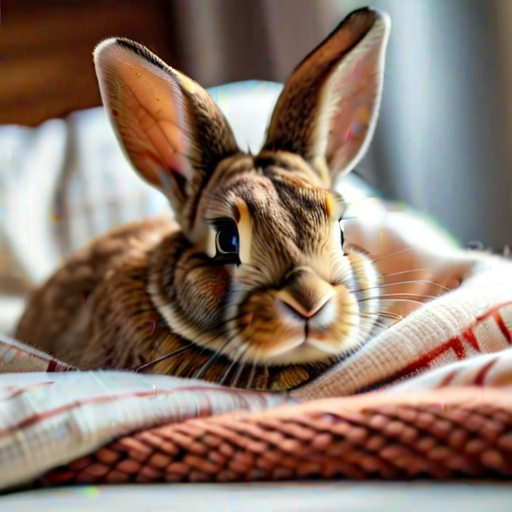

In [40]:
print("Image Path:", image_paths[10])
print("Prompt:", prompts[10])
print("Category:", categories[10])
images[10]

### Loading OpenCLIP

We'll use `OpenCLIPEmbeddings` from LangChain to generate embeddings for both images and text.

In [41]:
import open_clip

open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [42]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Load OpenCLIP model
MODEL = "ViT-H-14-378-quickgelu"
CHECKPOINT = "dfn5b"

# Initialize OpenCLIP embeddings
image_embedding = OpenCLIPEmbeddings(model_name=MODEL, checkpoint=CHECKPOINT)

### Creating a Multimodal Vector Store Index

We'll create a Pinecone index to store image embeddings, which can later be queried using text or image embeddings.

In [ ]:
import os
try:
    from pinecone.grpc import PineconeGRPC as Pinecone
except: 
    from pinecone import Pinecone

# Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

# Define Pinecone index
index_name = "langchain-opentutorial-multimodal-1024"
namespace = "image-1024"

# Check existing index name
all_indexes = pc.list_indexes()
print(f"Full Index Data: {all_indexes}")
existing_indexes = [index.name for index in all_indexes]
print(f"Extracted Index Names: {existing_indexes}")

# Check existing index and handle deletion/creation
if index_name in existing_indexes:
    print(f"Using existing index: {index_name}")
    index = pc.Index(index_name)
else:
    print(f"Creating new index: {index_name}")
    pc.create_index(
        index_name,
        dimension=1024,
        metric="dotproduct",
        spec=spec,
    )
    index = pc.Index(index_name)

Full Index Data: [{
    "name": "langchain-opentutorial-index",
    "dimension": 3072,
    "metric": "dotproduct",
    "host": "langchain-opentutorial-index-9v46jum.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}]
Extracted Index Names: ['langchain-opentutorial-index']
Creating new index: langchain-opentutorial-multimodal-1024


![04-pinecone-multimodal-index.png](./assets/04-pinecone-multimodal-02.png)

### Uploading Data to Pinecone

Using the OpenCLIP model, we vectorize the images and upload the vectors to the Pinecone index.

In [44]:
from tqdm import tqdm

namespace = "Pupba-animal-180"
vectors = []

for img_path, prompt, category in tqdm(zip(image_paths, prompts, categories), total=len(image_paths), desc="Processing images"):
    # Generate image embeddings
    image_vector = image_embedding.embed_image([img_path])[0]

    # Prepare vector for Pinecone
    vectors.append({
        "id": os.path.basename(img_path),
        "values": image_vector,
        "metadata": {
            "prompt": prompt,
            "category": category,
            "file_name": os.path.basename(img_path),
        }
    })

# Upsert vectors to Pinecone
index.upsert(vectors=vectors, namespace=namespace)

print(f"Uploaded {len(vectors)} images to Pinecone.")

Processing images: 100%|██████████| 50/50 [04:45<00:00,  5.70s/it]


Uploaded 50 images to Pinecone.


![04-pinecone-multimodal-data.png](./assets/04-pinecone-multimodal-01.png)

### Batch Processing with Parallelism

For larger datasets, we can speed up the process using batch processing and parallelism.

In [45]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# settings
BATCH_SIZE = 10
MAX_WORKERS = 4
namespace = "Pupba-animal-180-batch-workers"

def process_batch(batch):
    batch_vectors = []
    for img_path, prompt, category in batch:
        image_vector = image_embedding.embed_image([img_path])[0]
        batch_vectors.append({
            "id": os.path.basename(img_path),
            "values": image_vector,
            "metadata": {
                "prompt": prompt,
                "category": category,
                "file_name": os.path.basename(img_path),
            }
        })
    return batch_vectors

batches = [
    list(zip(image_paths[i:i + BATCH_SIZE], prompts[i:i + BATCH_SIZE], categories[i:i + BATCH_SIZE]))
    for i in range(0, len(image_paths), BATCH_SIZE)
]

# Parallel processing
vectors = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = list(tqdm(executor.map(process_batch, batches), total=len(batches), desc="Processing batches"))

    for batch_vectors in futures:
        vectors.extend(batch_vectors)

        index.upsert(vectors=batch_vectors, namespace=namespace)

print(f"Uploaded {len(vectors)} images to Pinecone.")

Processing batches: 100%|██████████| 5/5 [04:38<00:00, 55.74s/it] 


Uploaded 50 images to Pinecone.


![04-pinecone-multimodal-03.png](./assets/04-pinecone-multimodal-03.png)

### Search by Text and Image

Once the data is uploaded, we can query the index using either text or images.

**Text-Based Search**

In [46]:
from PIL import Image
import matplotlib.pyplot as plt

def search_by_text(query, top_k=5):
    print(f"Text Query: {query}")
    query_vector = image_embedding.embed_query([query])
    results = index.query(vector=query_vector, top_k=top_k, namespace=namespace, include_metadata=True)

    # Display results
    fig, axes = plt.subplots(1, len(results["matches"]), figsize=(15, 5))
    for ax, result in zip(axes, results["matches"]):
        print(f"Category: {result['metadata']['category']}, Prompt: {result['metadata']['prompt']}, Score: {result['score']}")
        img_file = result['metadata']['file_name']
        img_full_path = next((path for path in image_paths if os.path.basename(path) == img_file), None)
        if img_full_path:
            img = Image.open(img_full_path)
            ax.imshow(img)
            ax.set_title(f"Score: {result['score']:.2f}")
            ax.axis("off")
    plt.show()

**Image-Based Search**

In [47]:
def search_by_image(img_path, top_k=5):
    print(f"Image Query: {img_path}")
    query_vector = image_embedding.embed_image([img_path])

    # Check and convert vector formats
    if isinstance(query_vector, list) and isinstance(query_vector[0], list):
        query_vector = query_vector[0]  # If it is a nested list, extract the first list

    results = index.query(vector=query_vector, top_k=top_k, namespace=namespace, include_metadata=True)

    # Display results
    fig, axes = plt.subplots(1, len(results["matches"]), figsize=(15, 5))
    for ax, result in zip(axes, results["matches"]):
        print(f"Category: {result['metadata']['category']}, Prompt: {result['metadata']['prompt']}, Score: {result['score']}")
        img_file = result['metadata']['file_name']
        img_full_path = next((path for path in image_paths if os.path.basename(path) == img_file), None)
        if img_full_path:
            img = Image.open(img_full_path)
            ax.imshow(img)
            ax.set_title(f"Score: {result['score']:.2f}")
            ax.axis("off")
    plt.show()

**Testing Searches**

=== Text-Based Search ===
Text Query: a running elephant
Category: elephant, Prompt: a majestic elephant walking through the savanna, golden sunlight illuminating its wrinkled skin, highly detailed, 8k resolution., Score: 0.36785552
Category: elephant, Prompt: a baby elephant exploring its surroundings, soft sunlight, highly detailed, photorealistic, adorable and realistic., Score: 0.365934
Category: elephant, Prompt: an elephant walking through a dusty savanna, soft natural lighting, highly detailed, photorealistic, natural textures., Score: 0.36491212


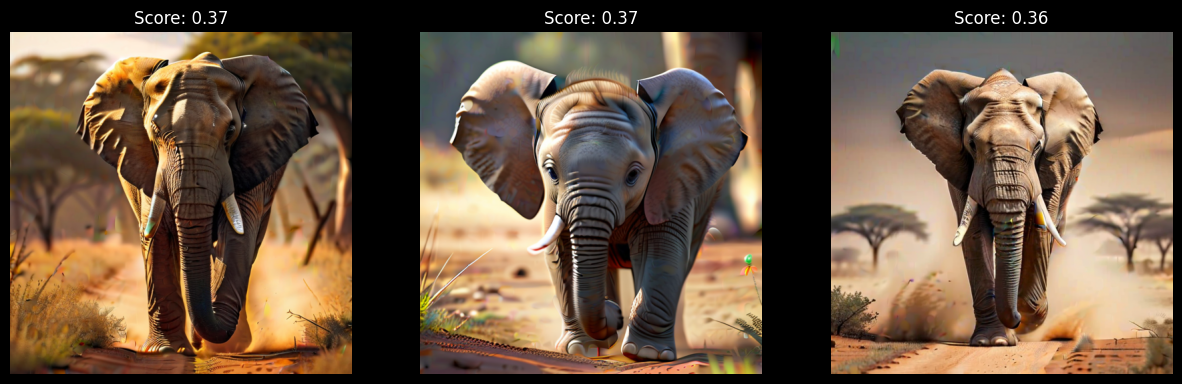


=== Image-Based Search ===
Image Query: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmp30e8byxo.png
Category: rabbit, Prompt: a fluffy white rabbit sitting in a grassy meadow, soft sunlight illuminating its fur, highly detailed, 8k resolution., Score: 1.0000001
Category: rabbit, Prompt: a rabbit playing in a meadow, soft sunlight, vibrant colors, highly detailed, ultra-realistic, 8k resolution., Score: 0.95482814
Category: rabbit, Prompt: a rabbit hopping through a grassy field, soft moonlight, white colors, highly detailed, photorealistic, 8k resolution., Score: 0.9535866


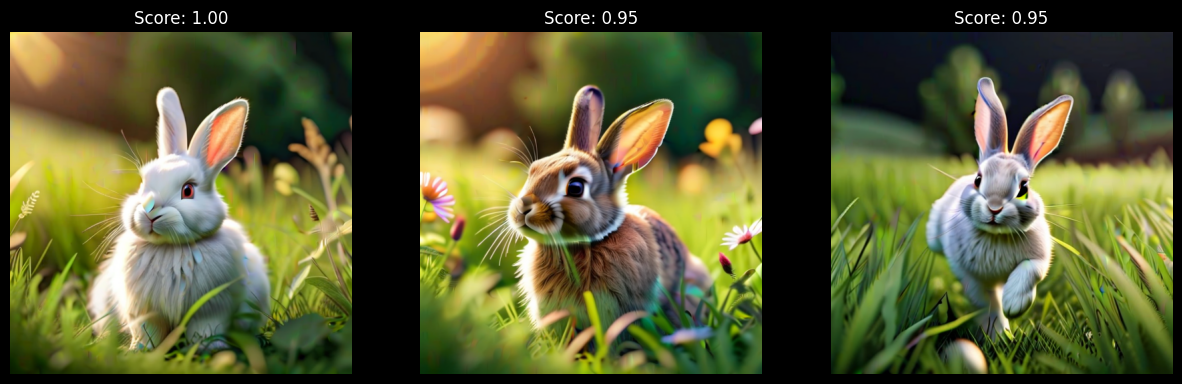

In [49]:
# Text search example
print("=== Text-Based Search ===")
text_query = "a running elephant"
search_by_text(text_query, top_k=3)

# Image search example
print("\n=== Image-Based Search ===")
image_query_path = image_paths[0]
search_by_image(image_query_path, top_k=3)